In [7]:
!pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

%matplotlib inline

## support functions

In [8]:
TOKEN_NUM_BYTES = 32

In [9]:
def rand_string(n_str=8) -> str:
    alphabet = string.ascii_letters + string.digits
    return "".join(secrets.choice(alphabet) for _ in range(n_str))


def rand_bytes(n_bytes=TOKEN_NUM_BYTES) -> bytes:
    if n_bytes <= 0:
        raise ValueError("0 and negative argument not allowed")
    return secrets.token_bytes(n_bytes)

In [10]:

def bytes_to_int(bytes_hex: bytes, byteorder="big"):
    return int.from_bytes(bytes_hex, byteorder=byteorder)


def int_to_bytes(i: int, n_bytes=TOKEN_NUM_BYTES, byteorder="big") -> bytes:
    if n_bytes is None:
        n_bytes = (i.bit_length() + 7) // 8 or 1
    return i.to_bytes(length=n_bytes, byteorder=byteorder)


def hex_str_to_int(str_hex: str, byteorder: str="big") -> int:
    return bytes_to_int(hex_str_to_bytes(str_hex), byteorder=byteorder)


def int_to_hex_str(i: int, n_bytes=TOKEN_NUM_BYTES, prefix="", byteorder="big") -> str:
    return bytes_to_hex_str(int_to_bytes(i, n_bytes, byteorder), prefix=prefix)


def hex_str_to_bytes(str_hex: str) -> bytes:
    if isinstance(str_hex, bytes):
        return str_hex
    str_hex = str_hex.lower()
    if str_hex.startswith("0x"):
        str_hex = str_hex[2:]
    if len(str_hex) & 1:
        str_hex = "0" + str_hex
    return bytes.fromhex(str_hex)


def bytes_to_hex_str(bytes_hex: bytes, prefix="") -> str:
    return prefix + bytes_hex.hex()




# Difficulty functions

In [11]:
ZERO_MASK = [0xFF, 0x7F, 0x3F, 0x1F, 0x0F, 0x07, 0x03, 0x01]


def difficulty_to_boundary(difficulty: int) -> bytes:
    boundary = bytearray(b"\xFF" * 32)
    n_bytes_to_zero = difficulty // 8
    n_bits_to_zero = difficulty % 8

    boundary[0:n_bytes_to_zero] = b"\x00" * n_bytes_to_zero
    boundary[n_bytes_to_zero] = ZERO_MASK[n_bits_to_zero]

    return bytes(boundary)


def boundary_to_difficulty(boundary) -> int:
    if isinstance(boundary, str):
        boundary = hex_str_to_bytes(boundary)

    difficulty = 0
    for b in memoryview(boundary):
        if b == 0:
            difficulty += 8
        else:
            difficulty += (8 - b.bit_length())
            break
    return difficulty


assert boundary_to_difficulty(difficulty_to_boundary(55)) == 55
assert boundary_to_difficulty(difficulty_to_boundary(55)) != 56

In [12]:
dividend = 0xffff000000000000000000000000000000000000000000000000000000000000


def boundary_to_hashpower(boundary) -> int:
    if isinstance(boundary, str):
        return dividend // hex_str_to_int(boundary)
    elif isinstance(boundary, bytes):
        return dividend // bytes_to_int(boundary)
    raise TypeError("Type of boundary should be str or bytes")


def difficulty_to_hashpower(difficulty: int) -> int:
    return boundary_to_hashpower(difficulty_to_boundary(difficulty))

In [13]:
import math
def convert_hashrate(hashrate, k=1000):
    if hashrate <= 0:
        return "0 Mh"
    
    rates = ['h', 'Kh', 'Mh', 'Gh', 'Th', 'Ph', 'Eh', 'Zh', 'Yh']
    i = math.floor(math.log(hashrate) / math.log(k));
    
    return f"{hashrate / pow(k, i):.2f} {rates[i]}"

## Plot current difficulty vs HashRate

In [14]:
POW_WINDOW = 150

030 --  1.07 Gh          --  7.16 Mh
031 --  2.15 Gh          --  14.32 Mh
032 --  4.29 Gh          --  28.63 Mh
033 --  8.59 Gh          --  57.27 Mh
034 --  17.18 Gh         --  114.53 Mh
035 --  34.36 Gh         --  229.06 Mh
036 --  68.72 Gh         --  458.12 Mh
037 --  137.44 Gh        --  916.25 Mh
038 --  274.87 Gh        --  1.83 Gh
039 --  549.75 Gh        --  3.66 Gh
040 --  1.10 Th          --  7.33 Gh
041 --  2.20 Th          --  14.66 Gh
042 --  4.40 Th          --  29.32 Gh
043 --  8.80 Th          --  58.64 Gh
044 --  17.59 Th         --  117.28 Gh
045 --  35.18 Th         --  234.56 Gh
046 --  70.37 Th         --  469.12 Gh
047 --  140.74 Th        --  938.24 Gh
048 --  281.47 Th        --  1.88 Th
049 --  562.94 Th        --  3.75 Th
050 --  1.13 Ph          --  7.51 Th
051 --  2.25 Ph          --  15.01 Th
052 --  4.50 Ph          --  30.02 Th
053 --  9.01 Ph          --  60.05 Th
054 --  18.01 Ph         --  120.09 Th
055 --  36.03 Ph         --  240.19 Th
056 --  7

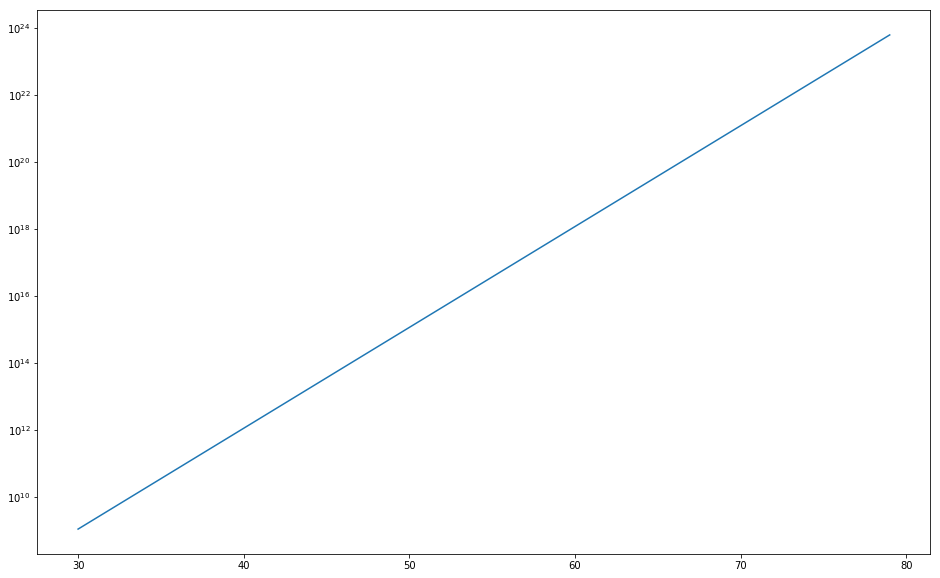

In [15]:
diff_list = list(range(30, 80))
hash_list = [difficulty_to_hashpower(d) for d in diff_list]
plt.figure(figsize=(16, 10))
plt.yscale("log")
plt.plot(diff_list, hash_list);

for diff, hashpower in zip(diff_list, hash_list):
    print(f"{diff:03} -- ", f"{convert_hashrate(hashpower):15s}", " -- ", convert_hashrate(hashpower // POW_WINDOW))

## New propose

hashrate *1.25 for next level instead of *2

In [16]:
N_DIVIDED = 4

In [17]:
ZERO_MASK = [0xFF, 0x7F, 0x3F, 0x1F, 0x0F, 0x07, 0x03, 0x01]


def calc_zero_bytes(difficulty_level):
    boundary = bytearray(b"\xFF" * 32)
    
    n_bytes_to_zero = difficulty_level // 8
    n_bits_to_zero = difficulty_level % 8
    
    boundary[0:n_bytes_to_zero] = b"\x00" * n_bytes_to_zero
    boundary[n_bytes_to_zero] = ZERO_MASK[n_bits_to_zero]
    
    return bytes(boundary)
    

def new_difficulty_to_boundary(difficulty: int) -> bytes:    
    if difficulty < 32:
        difficulty_level =  difficulty
        return calc_zero_bytes(difficulty_level)
    else:
        n = (difficulty - 32) // N_DIVIDED
        m = (difficulty - 32) % N_DIVIDED
        difficulty_level = 32 + n
            
    int_boundary = bytes_to_int(calc_zero_bytes(difficulty_level))
    boundary_change_step = (int_boundary >> 1) // N_DIVIDED
    
    boundary = int_boundary - boundary_change_step * m
    
    return int_to_bytes(boundary, n_bytes=32)


def new_boundary_to_difficulty(boundary) -> int:
    if isinstance(boundary, str):
        boundary = hex_str_to_bytes(boundary)

    difficulty_level = 0
    for b in memoryview(boundary):
        if b == 0:
            difficulty_level += 8
        else:
            difficulty_level += (8 - b.bit_length())
            break
            
    if difficulty_level < 32:
        return difficulty_level
    
    int_boundary = bytes_to_int(boundary)
    
    int_boundary_cur_level = bytes_to_int((calc_zero_bytes(difficulty_level)))
    boundary_change_step = (int_boundary_cur_level >> 1) // N_DIVIDED
    
    m = (int_boundary_cur_level - int_boundary ) // boundary_change_step
    
    n = (difficulty_level - 32)
    new_difficulty = 32 + n * N_DIVIDED    
    
    return new_difficulty + m


for d in range(1, 256):
    assert new_boundary_to_difficulty(new_difficulty_to_boundary(d)) == d


In [18]:
def new_difficulty_to_hashpower(difficulty: int) -> int:
    return boundary_to_hashpower(new_difficulty_to_boundary(difficulty))

## Plot new difficulty vs HashRate

In [19]:
def plot_new_diff(diff_list, n_divided=4):
    global N_DIVIDED
    N_DIVIDED = n_divided
    new_hash_list = [new_difficulty_to_hashpower(d) for d in diff_list]
    plt.scatter(diff_list, new_hash_list, label=f"Divided 1/{n_divided}")
    plt.legend()
    return new_hash_list
    

030 --  1.07 Gh        
031 --  2.15 Gh        
032 --  4.29 Gh        
033 --  4.91 Gh        
034 --  5.73 Gh        
035 --  6.87 Gh        
036 --  8.59 Gh        
037 --  9.82 Gh        
038 --  11.45 Gh       
039 --  13.74 Gh       
040 --  17.18 Gh       
041 --  19.63 Gh       
042 --  22.91 Gh       
043 --  27.49 Gh       
044 --  34.36 Gh       
045 --  39.27 Gh       
046 --  45.81 Gh       
047 --  54.97 Gh       
048 --  68.72 Gh       
049 --  78.54 Gh       
050 --  91.62 Gh       
051 --  109.95 Gh      
052 --  137.44 Gh      
053 --  157.07 Gh      
054 --  183.25 Gh      
055 --  219.90 Gh      
056 --  274.87 Gh      
057 --  314.14 Gh      
058 --  366.50 Gh      
059 --  439.80 Gh      
060 --  549.75 Gh      
061 --  628.28 Gh      
062 --  733.00 Gh      
063 --  879.60 Gh      


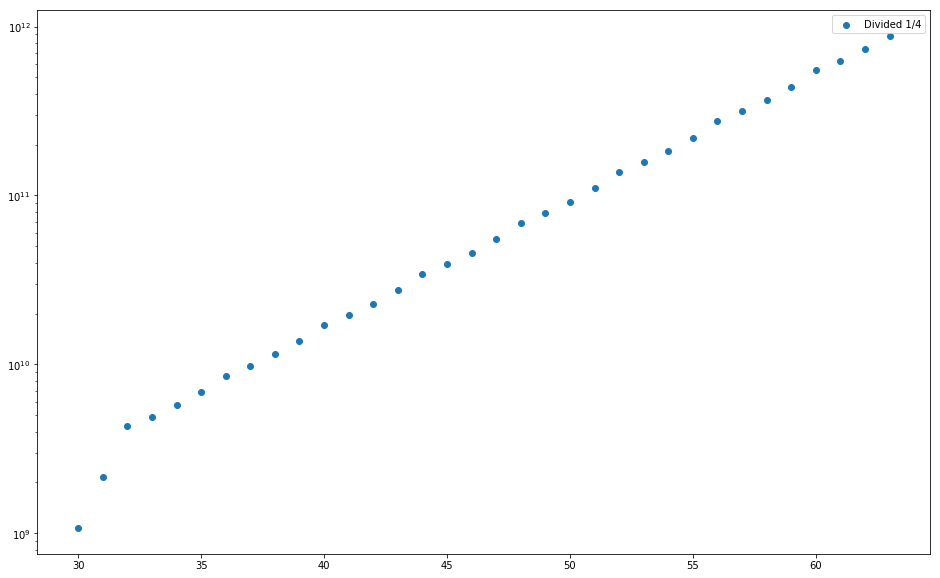

In [20]:
plt.figure(figsize=(16, 10))
plt.yscale("log")

diff_list = range(30, 64)
new_hash_list = plot_new_diff(diff_list, n_divided=4)

for diff, new_hashpower in zip(diff_list, new_hash_list):
    print(f"{diff:03} -- ", f"{convert_hashrate(new_hashpower):15s}")

030 --  1.07 Gh        
031 --  2.15 Gh        
032 --  4.29 Gh        
033 --  4.91 Gh        
034 --  5.73 Gh        
035 --  6.87 Gh        
036 --  8.59 Gh        
037 --  9.82 Gh        
038 --  11.45 Gh       
039 --  13.74 Gh       
040 --  17.18 Gh       
041 --  19.63 Gh       
042 --  22.91 Gh       
043 --  27.49 Gh       
044 --  34.36 Gh       
045 --  39.27 Gh       
046 --  45.81 Gh       
047 --  54.97 Gh       
048 --  68.72 Gh       
049 --  78.54 Gh       
050 --  91.62 Gh       
051 --  109.95 Gh      
052 --  137.44 Gh      
053 --  157.07 Gh      
054 --  183.25 Gh      
055 --  219.90 Gh      
056 --  274.87 Gh      
057 --  314.14 Gh      
058 --  366.50 Gh      
059 --  439.80 Gh      
060 --  549.75 Gh      
061 --  628.28 Gh      
062 --  733.00 Gh      
063 --  879.60 Gh      
064 --  1.10 Th        
065 --  1.26 Th        
066 --  1.47 Th        
067 --  1.76 Th        
068 --  2.20 Th        
069 --  2.51 Th        
070 --  2.93 Th        
071 --  3.52 Th 

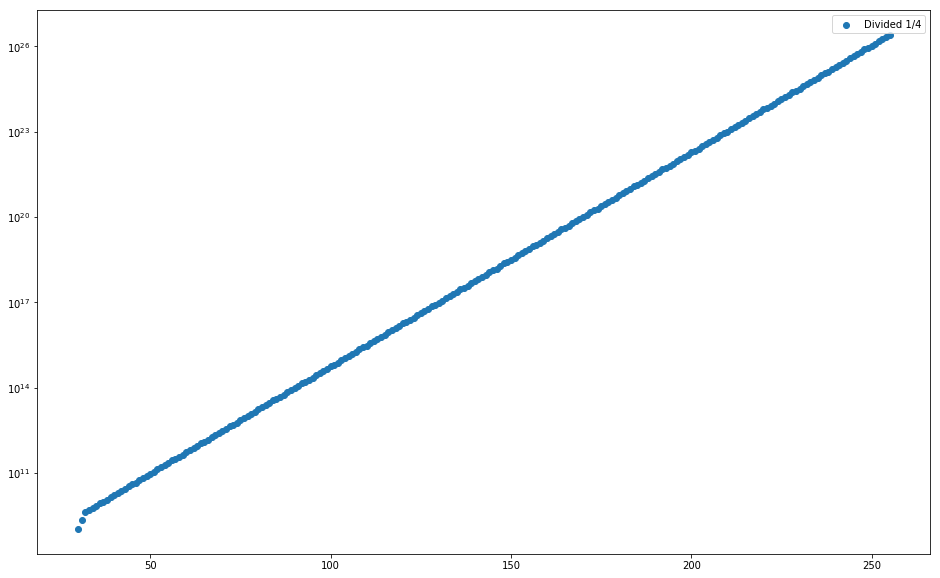

In [21]:
plt.figure(figsize=(16, 10))
plt.yscale("log")

diff_list = range(30, 256)
new_hash_list = plot_new_diff(diff_list, n_divided=4)

for diff, new_hashpower in zip(diff_list, new_hash_list):
    print(f"{diff:03} -- ", f"{convert_hashrate(new_hashpower):15s}")

028 --  268.43 Mh        --  268.43 Mh      
029 --  536.86 Mh        --  536.86 Mh      
030 --  1.07 Gh          --  1.07 Gh        
031 --  2.15 Gh          --  2.15 Gh        
032 --  4.29 Gh          --  4.29 Gh        
033 --  8.59 Gh          --  4.91 Gh        
034 --  17.18 Gh         --  5.73 Gh        
035 --  34.36 Gh         --  6.87 Gh        
036 --  68.72 Gh         --  8.59 Gh        
037 --  137.44 Gh        --  9.82 Gh        
038 --  274.87 Gh        --  11.45 Gh       
039 --  549.75 Gh        --  13.74 Gh       
040 --  1.10 Th          --  17.18 Gh       
041 --  2.20 Th          --  19.63 Gh       
042 --  4.40 Th          --  22.91 Gh       
043 --  8.80 Th          --  27.49 Gh       
044 --  17.59 Th         --  34.36 Gh       
045 --  35.18 Th         --  39.27 Gh       
046 --  70.37 Th         --  45.81 Gh       
047 --  140.74 Th        --  54.97 Gh       
048 --  281.47 Th        --  68.72 Gh       
049 --  562.94 Th        --  78.54 Gh       
050 --  1.

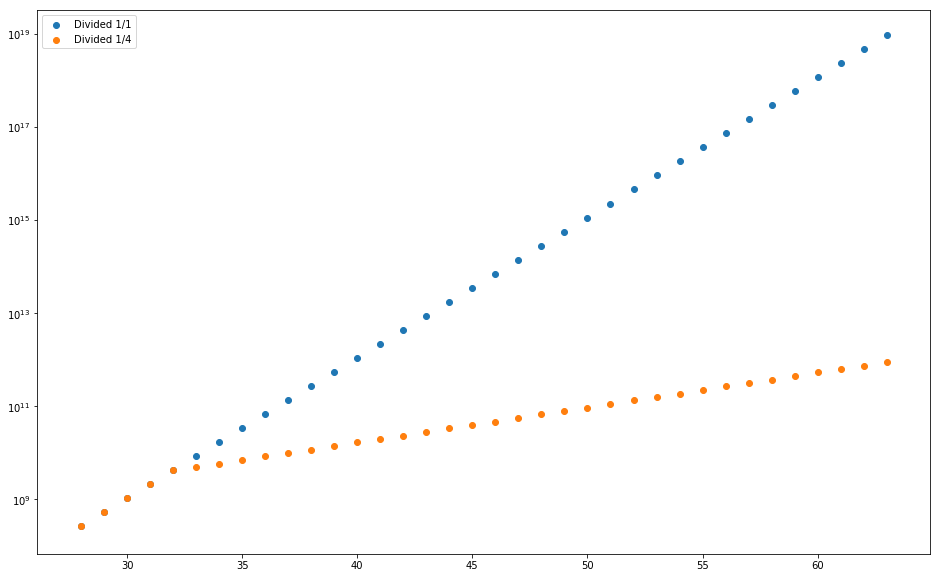

In [22]:
diff_list = list(range(28, 64))

plt.figure(figsize=(16, 10))
plt.yscale("log")

hash_list = plot_new_diff(diff_list, n_divided=1)
new_hash_list = plot_new_diff(diff_list, n_divided=4)

for diff, hashpower, new_hashpower in zip(diff_list, hash_list, new_hash_list):
    print(f"{diff:03} -- ", f"{convert_hashrate(hashpower):15s}", " -- ",  f"{convert_hashrate(new_hashpower):15s}")

## N_DIVIDED = 1, 2, 4, 6, 8

Level   Current              1/2                  1/4                  1/6                  1/8            
028  --  268.43 Mh        --  268.43 Mh        --  268.43 Mh        --  268.43 Mh        --  268.43 Mh      
029  --  536.86 Mh        --  536.86 Mh        --  536.86 Mh        --  536.86 Mh        --  536.86 Mh      
030  --  1.07 Gh          --  1.07 Gh          --  1.07 Gh          --  1.07 Gh          --  1.07 Gh        
031  --  2.15 Gh          --  2.15 Gh          --  2.15 Gh          --  2.15 Gh          --  2.15 Gh        
032  --  4.29 Gh          --  4.29 Gh          --  4.29 Gh          --  4.29 Gh          --  4.29 Gh        
033  --  8.59 Gh          --  5.73 Gh          --  4.91 Gh          --  4.69 Gh          --  4.58 Gh        
034  --  17.18 Gh         --  8.59 Gh          --  5.73 Gh          --  5.15 Gh          --  4.91 Gh        
035  --  34.36 Gh         --  11.45 Gh         --  6.87 Gh          --  5.73 Gh          --  5.29 Gh        
036  --  68.72 Gh   

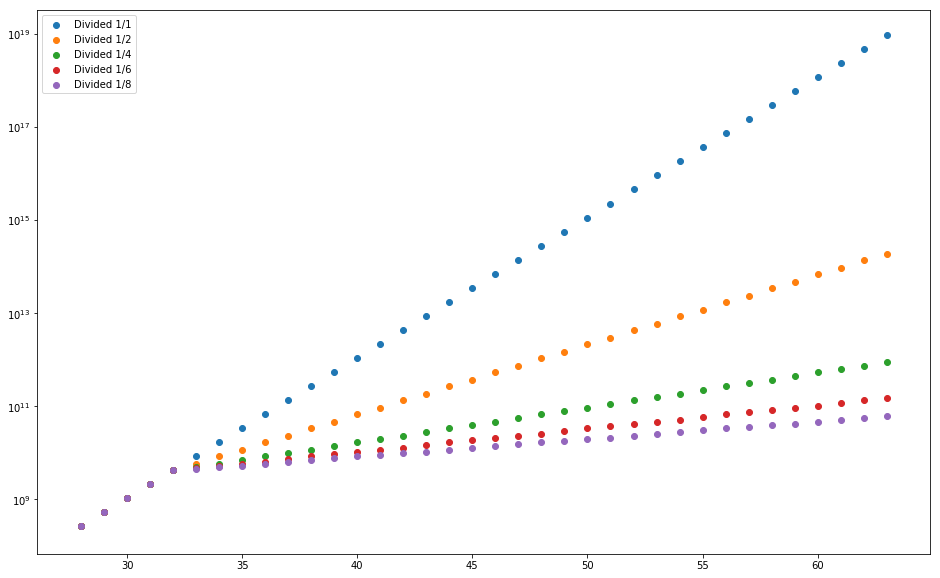

In [23]:
diff_list = list(range(28, 64))

plt.figure(figsize=(16, 10))
plt.yscale("log")

hash_list = plot_new_diff(diff_list, n_divided=1)
new_hash_list_2 = plot_new_diff(diff_list, n_divided=2)
new_hash_list_4 = plot_new_diff(diff_list, n_divided=4)
new_hash_list_6 = plot_new_diff(diff_list, n_divided=6)
new_hash_list_8 = plot_new_diff(diff_list, n_divided=8)


print(f"Level", 
      " ", f"{'Current':15s}", 
      "    ",  f"{'1/2':15s}",
      "    ",  f"{'1/4':15s}",
      "    ",  f"{'1/6':15s}",
      "    ",  f"{'1/8':15s}",
     )
    
for diff, hashpower, hashpower2, hashpower4, hashpower6, hashpower8 in zip(diff_list, 
                                                               hash_list, new_hash_list_2,
                                                               new_hash_list_4, new_hash_list_6, 
                                                               new_hash_list_8):
    print(f"{diff:03}", 
          " -- ", f"{convert_hashrate(hashpower):15s}", 
          " -- ",  f"{convert_hashrate(hashpower2):15s}",
          " -- ",  f"{convert_hashrate(hashpower4):15s}",
          " -- ",  f"{convert_hashrate(hashpower6):15s}",
          " -- ",  f"{convert_hashrate(hashpower8):15s}",
         )
    
    

Level      1/4                  1/6                  1/8            
028  --  268.43 Mh        --  268.43 Mh        --  268.43 Mh      
029  --  536.86 Mh        --  536.86 Mh        --  536.86 Mh      
030  --  1.07 Gh          --  1.07 Gh          --  1.07 Gh        
031  --  2.15 Gh          --  2.15 Gh          --  2.15 Gh        
032  --  4.29 Gh          --  4.29 Gh          --  4.29 Gh        
033  --  4.91 Gh          --  4.69 Gh          --  4.58 Gh        
034  --  5.73 Gh          --  5.15 Gh          --  4.91 Gh        
035  --  6.87 Gh          --  5.73 Gh          --  5.29 Gh        
036  --  8.59 Gh          --  6.44 Gh          --  5.73 Gh        
037  --  9.82 Gh          --  7.36 Gh          --  6.25 Gh        
038  --  11.45 Gh         --  8.59 Gh          --  6.87 Gh        
039  --  13.74 Gh         --  9.37 Gh          --  7.64 Gh        
040  --  17.18 Gh         --  10.31 Gh         --  8.59 Gh        
041  --  19.63 Gh         --  11.45 Gh         --  9.16 Gh  

222  --  805.94 Zh        --  13.83 Eh         --  57.65 Ph       
223  --  967.13 Zh        --  15.81 Eh         --  64.05 Ph       
224  --  1.21 Yh          --  18.45 Eh         --  72.06 Ph       
225  --  1.38 Yh          --  20.12 Eh         --  76.86 Ph       
226  --  1.61 Yh          --  22.14 Eh         --  82.35 Ph       
227  --  1.93 Yh          --  24.60 Eh         --  88.68 Ph       
228  --  2.42 Yh          --  27.67 Eh         --  96.08 Ph       
229  --  2.76 Yh          --  31.62 Eh         --  104.81 Ph      
230  --  3.22 Yh          --  36.89 Eh         --  115.29 Ph      
231  --  3.87 Yh          --  40.25 Eh         --  128.10 Ph      
232  --  4.84 Yh          --  44.27 Eh         --  144.11 Ph      
233  --  5.53 Yh          --  49.19 Eh         --  153.72 Ph      
234  --  6.45 Yh          --  55.34 Eh         --  164.70 Ph      
235  --  7.74 Yh          --  63.25 Eh         --  177.37 Ph      
236  --  9.67 Yh          --  73.79 Eh         --  192.15 Ph  

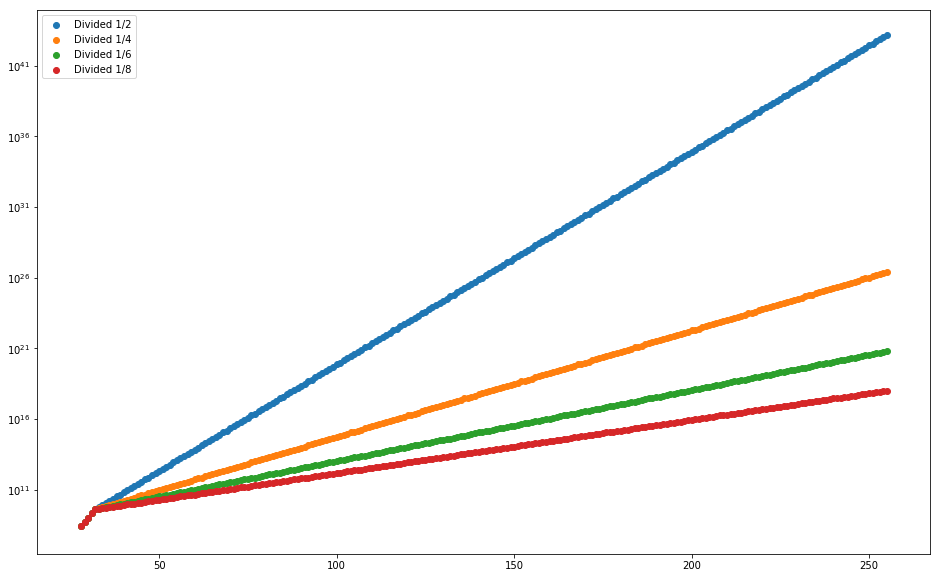

In [27]:
diff_list = list(range(28, 256))

plt.figure(figsize=(16, 10))
plt.yscale("log")

new_hash_list_2 = plot_new_diff(diff_list, n_divided=2)
new_hash_list_4 = plot_new_diff(diff_list, n_divided=4)
new_hash_list_6 = plot_new_diff(diff_list, n_divided=6)
new_hash_list_8 = plot_new_diff(diff_list, n_divided=8)


print(f"Level", 
      "    ",  f"{'1/4':15s}",
      "    ",  f"{'1/6':15s}",
      "    ",  f"{'1/8':15s}",
     )
    
for diff, hashpower4, hashpower6, hashpower8 in zip(diff_list, 
                                                               new_hash_list_4, new_hash_list_6, 
                                                               new_hash_list_8):
    print(f"{diff:03}", 
          " -- ",  f"{convert_hashrate(hashpower4):15s}",
          " -- ",  f"{convert_hashrate(hashpower6):15s}",
          " -- ",  f"{convert_hashrate(hashpower8):15s}",
         )
    
    